In [1]:
from pathlib import Path
import numpy as np
import supervision as sv
import cv2 as cv
import matplotlib.pyplot as plt

In [130]:
PATH_VID = Path("./material/focus_video.mov")

COLORS = (
    'blue','red','orange','green', 'brown', 
    'purple', 'teal', 'crimson', 'darkolivegreen', 'magenta')

# Parte 1: _Image Sharpness Measure for Blurred Images in Frequency Domain_

In [ ]:
def metric_ismfd(img: np.ndarray) -> float:
    """Calculates the Image Sharpness Measure in Frequency Domain metric for a given image.

    Args:
        img (np.ndarray): Grayscale image of shape (m,n).

    Returns:
        float: Metric as calculated on the image.
    """

    # Following paper line-by-line
    f = np.fft.fft2(img)
    fc = np.fft.fftshift(f)
    af = np.abs(fc)
    m = af.max().item()

    th = np.sum(f > (m/1000))

    return th / img.size 

In [ ]:
# info sobre el video
sv.VideoInfo.from_video_path(PATH_VID)

VideoInfo(width=640, height=360, fps=29, total_frames=171)

In [72]:
# helper
def grayscale_float_frames():
    for frame in sv.get_video_frames_generator(source_path=PATH_VID):
        x = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        x = x.astype(float)

        yield x

In [138]:
METRICS = dict()

## a) Midiendo sobre todo el frame

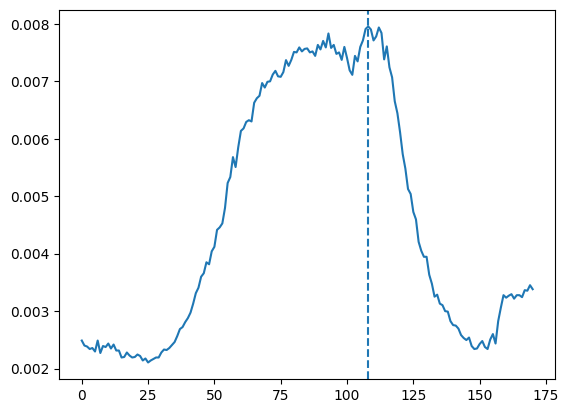

In [139]:
ism_whole_frame = np.array([metric_ismfd(img) for img in grayscale_float_frames()])

METRICS['ism_whole_frame'] = ism_whole_frame

plt.plot(ism_whole_frame)
lims = plt.ylim()
plt.vlines(ism_whole_frame.argmax(), *lims, linestyle='dashed')
plt.ylim(*lims)
plt.show()

Se observa un correcto aumento de la métrica bien alineado con el intervalo de tiempo en que la cámara hace foco en el video.

## b) Sobre ROI centrada

In [140]:
def get_center_roi(img: np.ndarray, area_fraction: float) -> np.ndarray:
    """Return the centered region of the image, determined by fraction of total area.
    Approximately preserves aspect ratio.

    Args:
        img (np.ndarray): Grayscale image of shape (m,n).
        area_fraction (float): Fraction of total area between 0 and 1.

    Returns:
        np.ndarray: Masked array.
    """
    h, w = img.shape
    frac = 0.5*np.sqrt(area_fraction)

    return img[
        int(h//2 - h*frac):int(h//2 + h*frac), 
        int(w//2 - w*frac):int(w//2 + w*frac)
    ]

In [141]:
for area_frac in (0.05, 0.1):
    METRICS[f"ism_roi_{area_frac}"] = np.array([
        metric_ismfd(get_center_roi(img, area_frac)) 
        for img in grayscale_float_frames()
    ])

[ism_whole_frame] max at frame 108
[   ism_roi_0.05] max at frame 111
[    ism_roi_0.1] max at frame 111


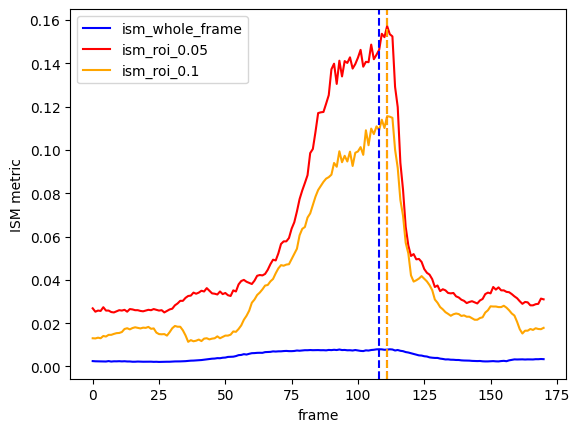

In [142]:
for (name, historic), color in zip(METRICS.items(),COLORS):
    plt.plot(historic, label=name, color=color)
    
lims = plt.ylim()
for (name, historic), color in zip(METRICS.items(),COLORS):
    argmax = historic.argmax()
    print(f"[{name: >15}] max at frame {argmax}")
    plt.vlines(argmax, *lims, linestyle='dashed',color=color)
plt.ylim(*lims)

plt.xlabel('frame')
plt.ylabel('ISM metric')
plt.legend(loc='upper left')
plt.show()

* Comparativamente con la métrica sobre todo el frame, las de ROI tienen un rango mucho mayor
* El máximo se encuentra muy cercano en todos los casos (108, 111, 111)
* El máximo coincide para ambos valores de área de ROI considerados
* En este gráfico no se aprecia, pero en el anterior se puede observar que la zona de enfoque del caso de frame completo está bien diferenciada.

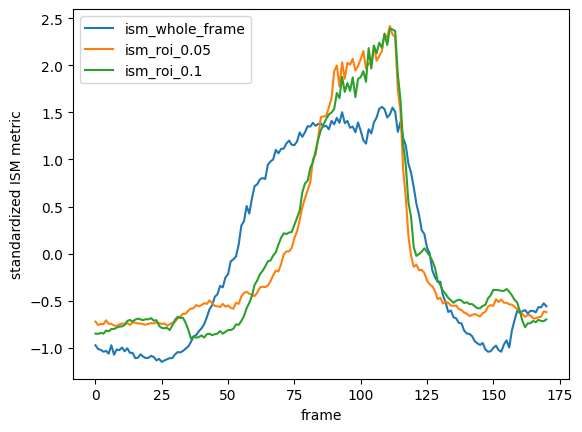

In [143]:
# extra: estandarización de las métricas para que tengan el mismo rango aprox.

for name, historic in METRICS.items():
    plt.plot((historic-historic.mean())/historic.std(), label=name)

plt.xlabel('frame')
plt.ylabel('standardized ISM metric')
plt.legend(loc='upper left')
plt.show()

Aplicada una estandarización, se observa que:

* La región considerada por el método a frame completo es bastante mayor y más "simétrica"
* Ambas fracciones de ROI son casi equivalentes en la zona de enfoque

# Parte 2: _Analysis of focus measure operators in shape-from-focus_

En el paper se menciona que los métodos de la familia del Laplaciano son los que mejor performan bajo condiciones normales. Los rankings sobre las tres familias de datos utilizados resaltan que los métodos $LAP2$ y $WAV1$ son muy buenos. El paper menciona que los basados en wavelet sufren menor deterioro en performance cuando se disminuye el _window size_ que los basados en el laplaciano. Por otra parte, $LAP2$ es casi un orden de magnitud más rápido que $WAV1$.

En base a estos datos, se seleccionó el método $LAP2$.

In [144]:
def metric_lap2(img: np.ndarray) -> float:
    """Calculates the LAP2 metric for a given image.

    Args:
        img (np.ndarray): Grayscale image of shape (m,n).

    Returns:
        float: Metric as calculated on the image.
    """

    # following the paper
    lap_kernel = np.array([-1,2,-1], dtype=float).reshape(-1,1)

    lx = cv.filter2D(img, -1, lap_kernel)
    ly = cv.filter2D(img, -1, lap_kernel.T)

    # LAP2 is the sum of absolute values of lx and ly
    return np.abs(lx).sum() + np.abs(ly).sum()

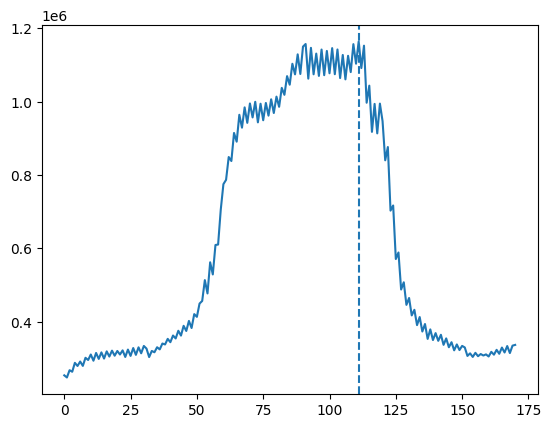

In [145]:
# se muestra uso
lap2_whole = np.array([metric_lap2(img) for img in grayscale_float_frames()])

METRICS['lap2_whole_frame'] = lap2_whole

plt.plot(lap2_whole)
lims = plt.ylim()
plt.vlines(lap2_whole.argmax(), *lims, linestyle='dashed')
plt.ylim(*lims)
plt.show()

In [146]:
for area_frac in (0.05, 0.1):
    METRICS[f"lap2_roi_{area_frac}"] = np.array([
        metric_lap2(get_center_roi(img, area_frac)) 
        for img in grayscale_float_frames()
    ])

[  lap2_whole_frame] max at frame 111
[     lap2_roi_0.05] max at frame 97
[      lap2_roi_0.1] max at frame 111


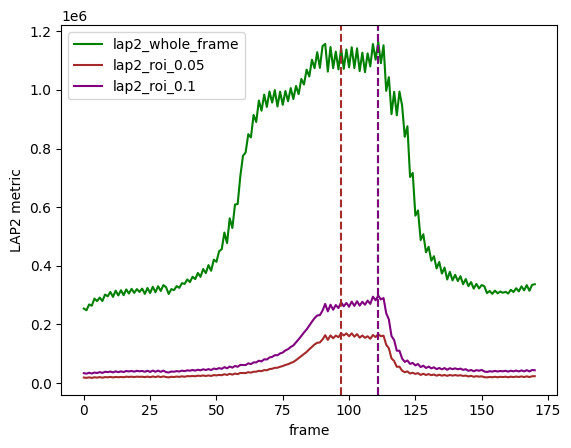

In [147]:
# ploteamos todos los LAP2 juntos
for (name, historic), color in zip(METRICS.items(),COLORS):
    if not name.startswith('lap2'): continue
    plt.plot(historic, label=name, color=color)
    
lims = plt.ylim()
for (name, historic), color in zip(METRICS.items(),COLORS):
    if not name.startswith('lap2'): continue
    argmax = historic.argmax()
    print(f"[{name: >18}] max at frame {argmax}")
    plt.vlines(argmax, *lims, linestyle='dashed',color=color)
plt.ylim(*lims)

plt.xlabel('frame')
plt.ylabel('LAP2 metric')
plt.legend(loc='upper left')
plt.show()

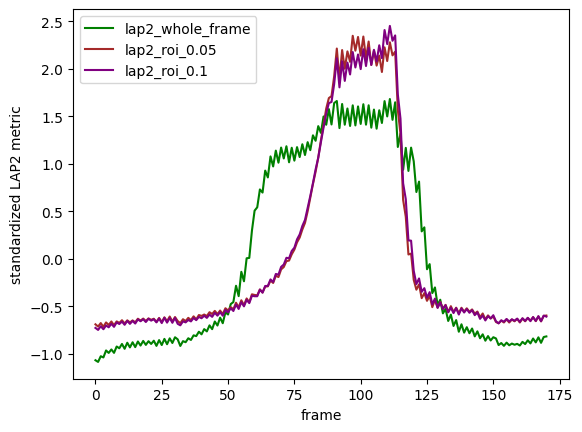

In [148]:
# volvemos a estandarizar para comparar curvas
for (name, historic), color in zip(METRICS.items(),COLORS):
    if not name.startswith('lap2'): continue
    plt.plot((historic-historic.mean())/historic.std(), label=name, color=color)
    

plt.xlabel('frame')
plt.ylabel('standardized LAP2 metric')
plt.legend(loc='upper left')
plt.show()

* El orden de magnitud de los valores es mucho mayor, especialmente en el caso de frame completo
* En dos casos el máximo es idéntico al del método anterior con ROI, para ROI chico es un poco distinto, acorde a lo antes mencionado en el paper.
* La forma de las curvas es similar al caso anterior: bastante asimétrico para ROI, más simétrico para frame completo.


En el paper y en la teoría en general se menciona que el Laplaciano es muy susceptible a ruido, se muestra utilización de suavizado gaussiano simple previo.

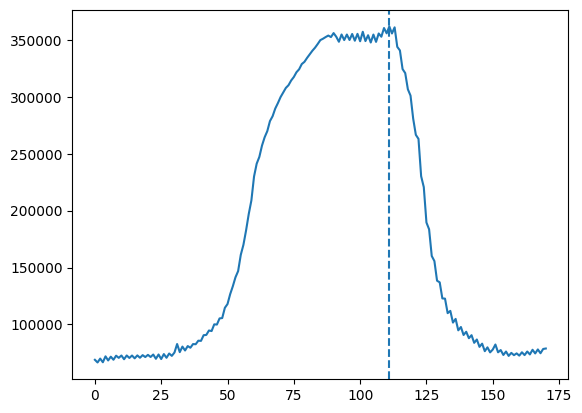

In [149]:
# con gaussian blur previo
lap2_whole_blurred = np.array([
    metric_lap2(cv.GaussianBlur(img, (5, 5), 1)) 
    for img in grayscale_float_frames()
])

plt.plot(lap2_whole_blurred)
lims = plt.ylim()
plt.vlines(lap2_whole_blurred.argmax(), *lims, linestyle='dashed')
plt.ylim(*lims)
plt.show()

El ruido se redujo mucho, aunque el máximo sigue en el mismo lugar.

In [150]:
METRICS['lap2_whole_blurred'] = lap2_whole_blurred

In [151]:
# replicamos para los ROI
# el blur lo aplicamos al ROI directamente

for area_frac in (0.05, 0.1):
    METRICS[f"lap2_roi_{area_frac}_blurred"] = np.array([
        metric_lap2(cv.GaussianBlur(get_center_roi(img, area_frac), (5, 5), 1)) 
        for img in grayscale_float_frames()
    ])

[lap2_whole_blurred] max at frame 111
[lap2_roi_0.05_blurred] max at frame 112
[lap2_roi_0.1_blurred] max at frame 112


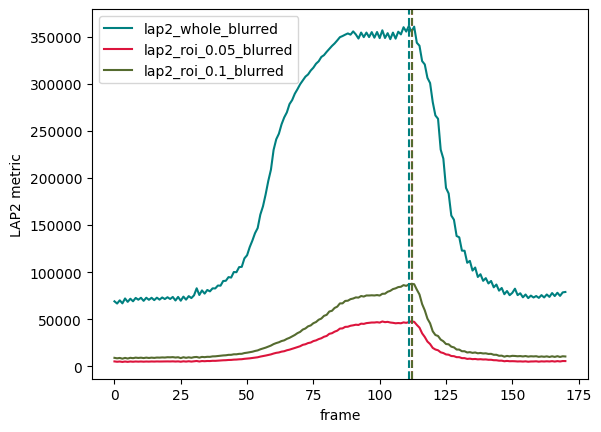

In [152]:
# volvemos a plotear, solo LAP2+blur
for (name, historic), color in zip(METRICS.items(),COLORS):
    if not (name.startswith('lap2') and name.endswith('blurred')): continue
    plt.plot(historic, label=name, color=color)
    
lims = plt.ylim()
for (name, historic), color in zip(METRICS.items(),COLORS):
    if not (name.startswith('lap2') and name.endswith('blurred')): continue
    argmax = historic.argmax()
    print(f"[{name: >18}] max at frame {argmax}")
    plt.vlines(argmax, *lims, linestyle='dashed',color=color)
plt.ylim(*lims)

plt.xlabel('frame')
plt.ylabel('LAP2 metric')
plt.legend(loc='upper left')
plt.show()

* El ROI 0.05 que antes detectaba un máximo diferente (por ruido) ahora es consistente con los demás
* Las curvas son mucho más suaves, sin detrimento de la detección de frame de máximo enfoque
* Ahora el frame de máximo enfoque detectado es el 112 en vez del 111, incluso si se considera un error, es despreciable.

# Extra 1: Matriz de enfoque

In [153]:
GRIDS = [(x,y) for x in (3,5,7) for y in (3,5,7)]

GRIDS

[(3, 3), (3, 5), (3, 7), (5, 3), (5, 5), (5, 7), (7, 3), (7, 5), (7, 7)]

# Extra 2: Unsharp Masking